### DRAFT OF COMBINED OFFSET AND ONSET DETECTION - Colm Forkin
Here we have a Frame-based analysis, low-level feature estimation: energy and maxima based approach to detecting Onsets and Offsets.
Based on considering energy, both onsets and offsets  are checked  in a monotonically increasing approach (frame by frame)  to the signal, that ensures that the offset detection is dependent on the onset detection, so no anomalies can occur.


The core function in this notebook is called myOnsetEnergyChecker().
This function returns "start_indexes, stop_indexes".
(apologies for using the word "index" here. This suggest it is an integer value.
They are actuall float time values in seconds.

There is additionaloutput parameters from the  
function  myOnsetEnergyChecker()  that allows consideration of other onset detection functions (e.g. onsets_hfc) and other information (split_decision_func) but for now these returned values are not considered in the Histogram Plots.

There are 4 audio files considered from Abessers Dataset
002,004,010,012 files (all .wwav)

The Histogram plots only considers the 002.wav (and corresponding 002.xml ground truth)

The full set of audio consider in the Data loader are area aligned with a set of ground truth values for both onset and offset. Ther are paired up as follows;


ground_t_offsets_array[0]---For audio 002.wav

ground_t_offsets_array[1]---For audio 004.wav

ground_t_offsets_array[2]---For audio 0010.wav

ground_t_offsets_array[3]---For audio 0012.wav


ground_t_onsets_array[0]---For audio 002.wav

ground_t_onsets_array[1]---For audio 004.wav

ground_t_onsets_array[2]---For audio 0010.wav

ground_t_onsets_array[3]---For audio 0012.wav


The function get_devs() calculates the difference between the ground truth for the onsets and the offsets. It takes a threshold (float) value which is the max. deviation allowed for a late or early onset/offset.

When you go outside this threshold, then you get into the territory known as "imposter notes" and "missing notes".
This issue is not considered yet in this notebook, but can be added later.

It is envisioned to have a more elaborate Dataloader taht will be built using a loop and will load a greater number of audio, considering also the Trinity Songs with Ground Truth Annotations (to be done)


There is a lot of code related to drawing plots which is commented out for now.
There is a lot of debug print code, for checking the length of the arrays returned from the various functions.
Apologies if this creates noise, but this code was important for integrity checks.

# There are 2 "ghost" functions (functions not invoked)
Ramons onset function (onset_SOP) is not invoked here. This is included to allow consideration of more sophisticated onset detection.

calculateOffsetOnset() is not invoked. This my original algorithm for offset detection. Its independent of onset detection and that is a problem.


In [1]:
!pip3 install essentia

     |████████████████████████████████| 12.0 MB 176 kB/s 


In [2]:
!pip3 install madmom

     |████████████████████████████████| 20.0 MB 1.2 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
  Created wheel for madmom: filename=madmom-0.16.1-cp37-cp37m-linux_x86_64.whl size=20934194 sha256=c44e73eb0cb966ed408bca2a582e7fb3b05bb06ab882f3055115dd01b25f72fd
  Stored in directory: /root/.cache/pip/wheels/af/90/61/393ceef814b55b12d1b59b5ed3a2b2a3457a55d39b7363b975
Successfully built madmom


In [3]:
!pip3 install mir_eval

     |████████████████████████████████| 87 kB 4.5 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-py3-none-any.whl size=96514 sha256=5efece4d9a7d4b435eec25da7d932777511b91af931dae06b65b7f25f067bf29
  Stored in directory: /root/.cache/pip/wheels/08/28/2d/006dbad29550bac8daf049ff34fa882655a7d3e77f3b67595e
Successfully built mir-eval


The section below is all path dependent

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
root = 'drive/MyDrive/Bass/'
import pandas as pd
import sys
sys.path.append(root)

Mounted at /content/drive


In [5]:
# TODO 1 optimise imports
from essentia.standard import *
from essentia import Pool, array
import essentia.standard as es
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import pandas as pd
import os
import madmom
import IPython
import pickle
from pickle import load
from scipy.signal import find_peaks
import ipywidgets as widgets
from scipy import signal
from lxml import etree
import mir_eval
from mir_eval import *
import plotly.express as px

In [7]:
# 1. Preparing the Dataset (annotations)
audio_files = [
'drive/MyDrive/Bass/abesser_music/002.wav',
'drive/MyDrive/Bass/abesser_music/004.wav',
'drive/MyDrive/Bass/abesser_music/010.wav',
'drive/MyDrive/Bass/abesser_music/012.wav']

# To Colm: consider converting them to .csv
annotation_files = [
 'drive/MyDrive/Bass/data_old/002.xml',
 'drive/MyDrive/Bass/data_old/004.xml',
 'drive/MyDrive/Bass/data_old/010.xml',
 'drive/MyDrive/Bass/data_old/012.xml']

assert(len(audio_files) == len(annotation_files))

ground_t_offsets_array = []
ground_t_onsets_array = []

# To Colm: just always use absolute time in the annotations.
# scaled_factor=1 #or fs depending on whether the graph uses time of samples

def extract_onsets_offsets_from_xml(xml_filename):
    with open(xml_filename, "rb") as f:
        tree = etree.parse(f)
    ground_t_offsets= []
    ground_t_onsets= []
    for x in tree.getroot().xpath("//offsetSec"):
        ground_t_offsets.append(float(x.text))
    for x in tree.getroot().xpath("//onsetSec"):
        ground_t_onsets.append(float(x.text))
    return ground_t_onsets, ground_t_offsets

for xml_file in annotation_files:
    ground_t_onsets, ground_t_offsets = extract_onsets_offsets_from_xml(xml_file)  
    ground_t_offsets_array.append(ground_t_offsets) 
    ground_t_onsets_array.append(ground_t_onsets) 


In [8]:
# 2. Load the audio for the Dataset
raw_audio = []
fs = 44100
for audio_file in audio_files:
    raw = MonoLoader(filename = audio_file, sampleRate = fs)()
    raw = raw / np.max(np.abs(raw))
    raw_audio.append(raw)

In [9]:
# 3. Defining accuracy metrics.
import scipy

def match_events(gt_onsets, onsets, matching_window_size):
    """
    Finds best matching pairs so
       - distance between elements is no greater than matching_window_size
       - sum of all distances is is minimized



       !!!!!!!!!!!!!!!!!!!!!!!!!1
Dont forget to extend this to consider Diferences

       !!!!!!!!!!!!!!!!!!!!!!!!!!!!

    """
    # In case of performance issues for big piecs,
    # we could try to use simpler/faster local algorithm.
    m = scipy.spatial.distance_matrix([[x] for x in gt_onsets], [[x] for x in onsets])
    # don't consider events which are out of matching window size
    big_distance = 10 ** 6
    m[m > matching_window_size] = big_distance

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(m)
    result = []

    for (x, y) in zip(row_ind, col_ind):
        if abs(gt_onsets[x] - onsets[y]) <= matching_window_size:
            result.append((x, y))
    return result


def f_measure(precision, recall):
    if precision == 0 and recall == 0:
        return 0.0
    return 2.0 * precision*recall / (precision + recall)


def evaluate_accuracy(gt_onsets, onsets, matching_window_size):
    matching = match_events(
        gt_onsets,
        onsets,
        matching_window_size)
    precision = float(len(matching)) / len(onsets)
    recall = float(len(matching)) / len(gt_onsets)
    f_measure_value = f_measure(precision, recall)
    return precision, recall, f_measure_value


In [10]:
#Setting the parameters try *2 also
windowSize = 1024*2
hopSize = 512*2
startIndexes = np.arange(0, raw_audio[0].size - windowSize, hopSize, dtype = int)#frame/window start indexes
numWindows = startIndexes.size

The energy of a discrete time signal can be computed as:
\begin{equation}
energy = \sum_{n = 0}^{N-1} |x[n]|^2
\end{equation}
where x[n] refers to the discrete time signal sample at index n

In [11]:
#Plot time-domain signal and the energy signal
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(raw_audio[0])
plt.title('Original sound signal')
plt.ylabel('amplitude')
plt.xlabel('sample indexes')
plt.axis('tight')

# perform windowing and feature estimation
# - features to be computed: energy and maximum amplitude
# - plot energy and maximum amplitude

NRG = np.zeros_like(startIndexes, dtype = float)#initializing the array for keeping energy values
maxVal = np.zeros_like(startIndexes, dtype = float)#initializing the array for maximum values

#Windowing (use variables: startIndexes and numWindows)
for k in range(numWindows):
    startInd = startIndexes[k]
    x_win = raw_audio[0][startInd : startInd + windowSize]
    NRG[k] = np.sum(np.power(x_win, 2))
    maxVal[k] = np.max(np.abs(x_win))

#Let's normalize the arrays for the simplicity of viewing them together
NRG = NRG / np.max(NRG)
maxVal = maxVal / np.max(maxVal)
dervNRG = NRG[1:] - NRG[:-1]#let's also compute the derivative of the energy and plot together
dervNRG[dervNRG < 0] = 0
plt.subplot(1, 2, 2)
plt.plot(NRG,label = 'Normalized energy')
plt.plot(maxVal, 'k', label = 'Max-val')
plt.plot(dervNRG, 'r', label = 'NRG derivative')
plt.title('Energy vs maxima')
plt.ylabel('amplitude')
plt.xlabel('sample indexes')
plt.axis('tight')
plt.legend(loc = 'best')
ipd.Audio(raw_audio[0], rate = fs)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
def calculateOffsetOnset(x,threshold,frameSize,hopSize,hopSizeScaleFactor):
  od1 = OnsetDetection(method='complex')#hfc
  rms_bands = []
  w = Windowing(type = 'hann')
  fft = FFT() # this gives us a complex FFT
  c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
  pool = essentia.Pool()
  for fstart in range(0, len(x)-frameSize, hopSize):
    frame = x[fstart:fstart+frameSize]
    rms_output= RMS()(frame)
    rms_bands.append(rms_output) # ONSET PART OF LOOP
    mag, phase, = c2p(fft(w(frame))) # ONSET PART OF LOOP
    pool.add('features.hfc', od1(mag, phase)) # ONSET PART OF LOOP
  #### ONSET CODE SECTION
  # Phase 2: compute the actual onsets locations
  onsets = Onsets()

  onsets_hfc = onsets(# this algo expects a matrix, not a vector
                      essentia.array([ pool['features.hfc'] ]),
                      # you need to specify weights, but as there is only a single
                      # function, it doesn't actually matter which weight you give it
                      [ 2 ])
  #### END ONSET CODE SECTION
  index= 0
  array_of_time_offsets= []
  flag = False
  last_index=0
  while index < len(rms_bands):
    if (abs(rms_bands[index])<threshold) and flag == False  and  (index!=0):
      # Skip very first
      array_of_time_offsets.append(index)
      flag = True
      last_index=index
    index+=1
    #We set flag back to false after determined time epriod
    increment_factor= int(hopSize/hopSizeScaleFactor)
    if index > last_index+increment_factor:
      flag = False
  a= array(array_of_time_offsets)
  fs=44100
  the_len= int(len(x)/hopSize)
  rms_bands1 = rms_bands[:the_len]
  b= (a*hopSize)/44100
  return(rms_bands1,b,onsets_hfc)

In [14]:
# Onset detection using Spectral Onset Processor blending ideas from Ramon
# myOnsetEnergyChecker
# Returns onsets_hfc,split_decision_func, start_indexes, stop_indexes
def myOnsetEnergyChecker(x,theFrameSize,theHopSize):
    fs = 44100
    od_hfc = OnsetDetection(method = 'hfc')
    od_complex = OnsetDetection(method = 'complex')
    w = Windowing(type = 'hann')
    fft = FFT() # this gives us a complex FFT
    c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    onsets = Onsets()
    NRG = [];
    pool = Pool()
    #Main windowing and feature extraction loop
    #for frame in es.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
    for frame in FrameGenerator(x, frameSize = theFrameSize, hopSize = theHopSize):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od_hfc(mag, phase))
        NRG.append(es.Energy()(frame))
        pool.add('features.complex', od_complex(mag, phase))

    onsets_hfc = onsets(array([pool['features.hfc']]),[1])
    onsets_complex = onsets(array([pool['features.complex']]), [1])
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > 0.05] = 1 # was 0.005
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize/fs
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize/fs
    return (onsets_complex,split_decision_func, start_indexes, stop_indexes)

### THIS IS RAMONS ONSET. I HAVE NO STRATEGY FOR BLENDING ONSET AND OFFSET HERE
### THIS FUNCITON IS NOT INVOKED IN THIS NOTEBOOK
def onset_SOP(audiofile):
    #Detection function
    fps = 200
    sodf = madmom.features.onsets.SpectralOnsetProcessor('superflux', diff_frames=20)
    sodf.processors[-1]  # doctest: +ELLIPSIS
    det_function = sodf(audiofile, fps = fps)
    det_function_norm = det_function/(max(det_function))

    #Dynamic threashold
    C_t = 0.99
    H = 100
    delta = 0.1

    din_th = np.zeros(len(det_function_norm))
    for m in range(H, len(det_function_norm)):
        din_th[m] = C_t*np.median(det_function_norm[m-H:m+H])+delta

    #Peak detection
    peaks, _ = find_peaks(det_function_norm, distance=fps/10, height = din_th)  
    onset_array = peaks/fps
    return onset_array

In [15]:
frameSize = 2048
hopSize = 1024
#print(len(onset2))
#print(len(offset2))


In [23]:
matching_window_size= 0.20 #ms


precision1b_tot=0
recall1b_tot=0
f_measure_value1b_tot=0

precision2b_tot=0
recall2b_tot=0
f_measure_value2b_tot=0

precision4_tot=0
recall4_tot=0
f_measure_value4_tot=0

stem_index=0
while stem_index <4:
   rms, offsetFirst, onsetFirst = calculateOffsetOnset(raw_audio[stem_index],0.1,frameSize,hopSize,90) # short inter note gap#
   onsets_complex,split_decision_func, onsetRamon, offsetRamon = myOnsetEnergyChecker(raw_audio[stem_index],frameSize,hopSize)
   onset_sop = onset_SOP(audio_files[stem_index])
   #onsetStemIndex, offsetStemIndex = onsetPitchMelody(audio_files[stem_index]) 

   precision1, recall1, f_measure_value1=    evaluate_accuracy(ground_t_offsets_array[stem_index], offsetFirst, matching_window_size)
   precision1b, recall1b, f_measure_value1b=    evaluate_accuracy(ground_t_onsets_array[stem_index], onsetFirst, matching_window_size)
   
   precision1b_tot+=precision1b
   recall1b_tot+=recall1b
   f_measure_value1b_tot+=f_measure_value1b

   precision2, recall2, f_measure_value2=    evaluate_accuracy(ground_t_offsets_array[stem_index], offsetRamon, matching_window_size)
   precision2b, recall2b, f_measure_value2b=    evaluate_accuracy(ground_t_onsets_array[stem_index], onsetRamon, matching_window_size)
  
   precision2b_tot+=precision2b
   recall2b_tot+=recall2b
   f_measure_value2b_tot+=f_measure_value2b
  
   precision4, recall4, f_measure_value4=    evaluate_accuracy(ground_t_onsets_array[stem_index], onset_sop, matching_window_size)
   print("Results for ",audio_files[stem_index],":" )
  
   precision4_tot+=precision4
   recall4_tot+=recall4
   f_measure_value4_tot+=f_measure_value4

   #print(round( precision1,3), round(recall1,3), round(f_measure_value1,3))
   #print("Accuracy for Offset: Colm method  EnergyChecker Indices")
   print("Accuracy for Onset: Colm method  EnergyChecker Indices")
   print(round( precision1b,3), round(recall1b,3), round(f_measure_value1b,3))


   #print(round(precision2,3), round(recall2,3), round(f_measure_value2,3))
   #print("Accuracy for Offset: Ramon method Indexed EnergyChecker Indices")
   print("Accuracy for Onset: Ramon method Indexed EnergyChecker Indices")
   print(round(precision2b,3), round(recall2b,3), round(f_measure_value2b,3))

   print("Accuracy for Onset: Ramon method Onset SOP")
   print(round(precision4,3), round(recall4,3), round(f_measure_value4,3))
   print("********************")
   stem_index+=1
print("=================")
print("TOTALS")
print("EC")
print(round((precision1b_tot/4),3))
print(round((recall1b_tot/4),3))
print(round((f_measure_value1b_tot/4),3))
print("IEC")
print(round((precision2b_tot/4),3))
print(round((recall2b_tot/4),3))
print(round((f_measure_value2b_tot/4),3))
print("SOP")
print(round((precision4_tot/4),3))
print(round((recall4_tot/4),3))
print(round((f_measure_value4_tot/4),3))


/usr/local/lib/python3.7/dist-packages/madmom/io/audio.py:493: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Results for  drive/MyDrive/Bass/abesser_music/002.wav :
Accuracy for Onset: Colm method  EnergyChecker Indices
0.446 0.521 0.481
Accuracy for Onset: Ramon method Indexed EnergyChecker Indices
1.0 0.688 0.815
Accuracy for Onset: Ramon method Onset SOP
0.923 1.0 0.96
********************
Results for  drive/MyDrive/Bass/abesser_music/004.wav :
Accuracy for Onset: Colm method  EnergyChecker Indices
0.518 0.518 0.518
Accuracy for Onset: Ramon method Indexed EnergyChecker Indices
1.0 0.5 0.667
Accuracy for Onset: Ramon method Onset SOP
0.812 1.0 0.896
********************
Results for  drive/MyDrive/Bass/abesser_music/010.wav :
Accuracy for Onset: Colm method  EnergyChecker Indices
0.35 0.515 0.417
Accuracy for Onset: Ramon method Indexed EnergyChecker Indices
1.0 0.691 0.817
Accuracy for Onset: Ramon method Onset SOP
0.932 1.0 0.965
********************
Results for  drive/MyDrive/Bass/abesser_music/012.wav :
Accuracy for Onset: Colm method  EnergyChecker Indices
0.388 0.517 0.443
Accuracy fo

In [ ]:


print("Results for 002.wav  precision , recal1, f_measure_value")
print("Accuracy for Offset: Colms method")ls

print(round( precision1,3), round(recal1,3), round(f_measure_value1,3))
print("Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision2,3), round(recal2,3), round(f_measure_value2,3))
print("Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision3,3), round(recal3,3), round(f_measure_value3,3))
print("Accuracy for Onset: Ramon method Onset SOP")
print(round(precision4,3), round(recal4,3), round(f_measure_value4,3))



In [ ]:
rms2, offsetFirst2, onsetFirst2 =calculateOffsetOnset(raw_audio[1],0.1,frameSize,hopSize,90) # short inter note gap
onsets_complex,split_decision_func, onsetSecond2, offsetSecond2 = myOnsetEnergyChecker(raw_audio[1],frameSize,hopSize)
onset_ramon2 = onset_SOP(audio_files[1])
matching_window_size= 0.15 #ms




print("Results for 004.wav    precision , recal1, f_measure_value")
print("Accuracy for Offset: Colms method")
print(round( precision1,3), round(recal1,3), round(f_measure_value1,3))
print("Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision2,3), round(recal2,3), round(f_measure_value2,3))
print("Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision3,3), round(recal3,3), round(f_measure_value3,3))
print("Accuracy for Onset: Ramon method Onset SOP")
print(round(precision4,3), round(recal4,3), round(f_measure_value4,3))



/usr/local/lib/python3.7/dist-packages/madmom/io/audio.py:493: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Results for 004.wav    precision , recal1, f_measure_value
Accuracy for Offset: Colms method
0.966 0.5 0.659
Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices
0.964 0.482 0.643
Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices
0.964 0.482 0.643
Accuracy for Onset: Ramon method Onset SOP
0.797 0.982 0.88


In [ ]:
rms2, offsetFirst2, onsetFirst2  =calculateOffsetOnset(raw_audio[2],0.1,frameSize,hopSize,90) # short inter note gap
onsets_complex,split_decision_func, onsetSecond2, offsetSecond2 = myOnsetEnergyChecker(raw_audio[2],frameSize,hopSize)
onset_ramon2 = onset_SOP(audio_files[2])
matching_window_size= 0.15 #ms

precision1, recal1, f_measure_value1=    evaluate_accuracy(golden_offsets_2, offsetFirst2, matching_window_size)
precision2, recal2, f_measure_value2=    evaluate_accuracy(golden_offsets_2, offsetSecond2, matching_window_size)
precision3, recal3, f_measure_value3=    evaluate_accuracy(golden_onsets_2, onsetSecond2, matching_window_size)
precision4, recal4, f_measure_value4=    evaluate_accuracy(golden_onsets_2, onset_ramon2, matching_window_size)



print("Results for 010.wav   precision , recal1, f_measure_value ")
print("Accuracy for Offset: Colms method")
print(round( precision1,3), round(recal1,3), round(f_measure_value1,3))
print("Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision2,3), round(recal2,3), round(f_measure_value2,3))
print("Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision3,3), round(recal3,3), round(f_measure_value3,3))
print("Accuracy for Onset: Ramon method Onset SOP")
print(round(precision4,3), round(recal4,3), round(f_measure_value4,3))



/usr/local/lib/python3.7/dist-packages/madmom/io/audio.py:493: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Results for 010.wav   precision , recal1, f_measure_value 
Accuracy for Offset: Colms method
0.435 0.294 0.351
Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices
0.489 0.338 0.4
Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices
0.766 0.529 0.626
Accuracy for Onset: Ramon method Onset SOP
0.74 0.794 0.766


In [ ]:
rms2, offset2, onset2 =calculateOffsetOnset(raw_audio[3],0.1,frameSize,hopSize,90) # short inter note gap
onsets_complex,split_decision_func, onsetSecond2, offsetSecond2 = myOnsetEnergyChecker(raw_audio[3],frameSize,hopSize)
onset_ramon2 = onset_SOP(audio_files[3])
matching_window_size= 0.15 #ms

precision1, recal1, f_measure_value1=    evaluate_accuracy(golden_offsets_3, offsetFirst2, matching_window_size)
precision2, recal2, f_measure_value2=    evaluate_accuracy(golden_offsets_3, offsetSecond2, matching_window_size)
precision3, recal3, f_measure_value3=    evaluate_accuracy(golden_onsets_3, onsetSecond2, matching_window_size)
precision4, recal4, f_measure_value4=    evaluate_accuracy(golden_onsets_3, onset_ramon2, matching_window_size)




print("Results for 012.wav    precision , recal1, f_measure_value ")
print("Accuracy for Offset: Colms method")
print(round( precision1,3), round(recal1,3), round(f_measure_value1,3))
print("Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision2,3), round(recal2,3), round(f_measure_value2,3))
print("Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices")
print(round(precision3,3), round(recal3,3), round(f_measure_value3,3))
print("Accuracy for Onset: Ramon method Onset SOP")
print(round(precision4,3), round(recal4,3), round(f_measure_value4,3))



/usr/local/lib/python3.7/dist-packages/madmom/io/audio.py:493: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Results for 012.wav    precision , recal1, f_measure_value 
Accuracy for Offset: Colms method
0.5 0.383 0.434
Accuracy for Offset: Ramon method myOnsetEnergyChecker Indices
0.571 0.4 0.471
Accuracy for Onset: Ramon method myOnsetEnergyChecker Indices
0.558 0.4 0.466
Accuracy for Onset: Ramon method Onset SOP
0.636 0.7 0.667


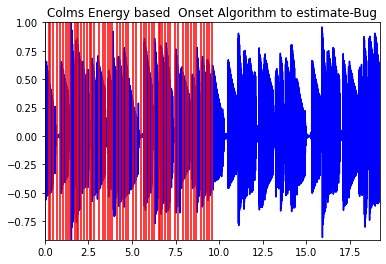

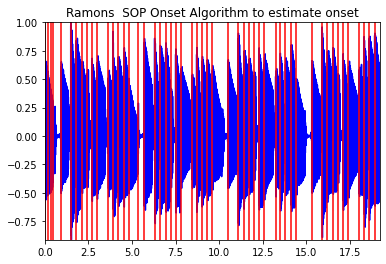

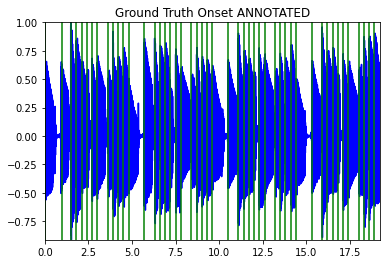

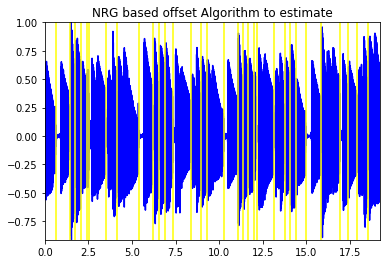

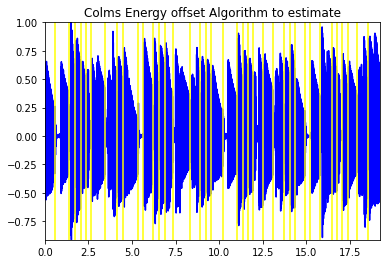

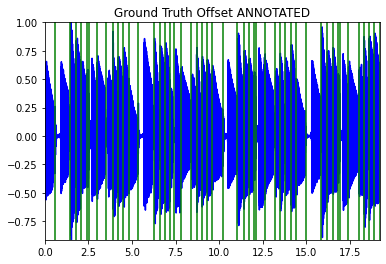

In [ ]:
########################################################################################

plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in onsets_complex:
    plt.axvline(x=i, color='red')
plt.title("Colms Energy based  Onset Algorithm to estimate-Bug")
plt.show()
########################################################################################


plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in onset_ramon2:
    plt.axvline(x=i, color='red')
plt.title("Ramons  SOP Onset Algorithm to estimate onset")
plt.show()
########################################################################################

golden_offsets_0 = array(ground_t_onsets_array[0])

plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in golden_offsets_0:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth Onset ANNOTATED")
plt.show()

########################################################################################
########################################################################################
########################################################################################

plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in offset2:
    plt.axvline(x=i, color='yellow')
plt.title("NRG based offset Algorithm to estimate")
plt.show()
########################################################################################

plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in offsetFirst2:
    plt.axvline(x=i, color='yellow')
plt.title("Colms Energy offset Algorithm to estimate")
plt.show()

########################################################################################

golden_onsets_0 = array(ground_t_offsets_array[0])

plt.plot(np.arange(raw_audio[0].size)/float(fs), raw_audio[0],'b')
plt.axis([0,raw_audio[0].size/float(fs),min(raw_audio[0]),max(raw_audio[0])])
for i in golden_onsets_0:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth Offset ANNOTATED")
plt.show()
########################################################################################


In [ ]:
print(len(audio_files[1]))
x4=audio_files[1]

In [ ]:
plt.plot(np.arange(x4.size)/float(fs), x4,'b')
plt.axis([0,x4.size/float(fs),min(x4),max(x4)])
for i in onset2:
    plt.axvline(x=i, color='red')
plt.title("Onset  Algorithm to estimate onset_SOP")
plt.show()


plt.plot(np.arange(x4.size)/float(fs), x4,'b')
plt.axis([0,x4.size/float(fs),min(x4),max(x4)])
for i in onset_2:
    plt.axvline(x=i, color='red')
plt.title("Onset  Algorithm to estimate calculateOffsetOnset" )
plt.show()


golden_offsets_0 = array(ground_t_onsets_array[0])

plt.plot(np.arange(x4.size)/float(fs), x4,'b')
plt.axis([0,x4.size/float(fs),min(x4),max(x4)])
for i in golden_offsets_0:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth Onset ANNOTATED")
plt.show()


plt.plot(np.arange(x4.size)/float(fs), x4,'b')
plt.axis([0,x4.size/float(fs),min(x4),max(x4)])
for i in offset2:
    plt.axvline(x=i, color='yellow')
plt.title("Colms offset Algorithm to estimate")
plt.show()

golden_onsets_0 = array(ground_t_offsets_array[0])

plt.plot(np.arange(x4.size)/float(fs), x4,'b')
plt.axis([0,x4.size/float(fs),min(x4),max(x4)])
for i in golden_onsets_0:
    plt.axvline(x=i, color='green')
plt.title("Ground Truth Offset ANNOTATED")
plt.show()

In [ ]:
evaluate_accuracy(ground_t_onsets_array[0], start_indexes, 0.1)

(0.9583333333333334, 0.9583333333333334, 0.9583333333333334)

In [ ]:
# Case of too many falses
# First parameter is the measured array 
# Second is the array of ground truth
# Thurd parameter is the threshold
def get_devs(measured, a_gt,thresh):
    print ("Measured...Ground Truth")
    agt_index=0
    measured_index=0
    agt_index= 0
    missing_notes=0

    matched_index= 0
    c_diff=[]
    c_a_gt=[]
    c_measured=[]
    while (agt_index < len(a_gt)):
      if agt_index >= 45: # CRUDE HACK
          break
      if (measured[measured_index]> a_gt[agt_index]):
          deviation = measured[measured_index]- a_gt[agt_index]
          print(" Then it is late", deviation)
      elif (measured[measured_index]< a_gt[agt_index]):
          diff =a_gt[agt_index]-measured[measured_index]
          deviation = -diff
          print(" Then it is early", deviation)
      elif (measured[measured_index]== a_gt[agt_index]):
          print(" Bang on")
          deviation=0
      if (abs(deviation) < thresh):
          print ("deviation is ", deviation)
          c_a_gt.append( a_gt[agt_index])
          c_measured.append( measured[measured_index])
          c_diff.append(deviation)
          measured_index+=1
          agt_index+=1
          matched_index+=1
      else:
        # In this case  we have gone off the scale
        # We need to determine imposter and missing notes.
          agt_index+=1  
          missing_notes+=1
    return(c_diff,missing_notes)



In [ ]:
thresh=1
off_cdiff_2,off_mn2 = get_devs(start_indexes,ground_t_offsets_array[0],thresh)
on_cdiff_2,on_mn2 = get_devs(stop_indexes,ground_t_onsets_array[0],thresh)

In [ ]:
off_cdiff_2

[]

In [ ]:
import pandas as pd

In [ ]:
data_timing2= { 'onset deviations' :on_cdiff_2}
data_timing2_off= { 'offset deviations' :off_cdiff_2}

In [ ]:
df2 = pd.DataFrame(data_timing2,columns=['onset deviations'])
fig = px.histogram(df2, x="onset deviations")
fig.show()
print(on_cdiff_2)

df2_off = pd.DataFrame(data_timing2_off,columns=['offset deviations'])
fig_off = px.histogram(df2_off, x="offset deviations")
fig_off.show()
print(off_cdiff_2)